### 1-Load data

In [11]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, RandomFlip, RandomZoom, RandomContrast, RandomRotation, Input, Flatten
import os
import shutil
import numpy as np
from keras.src.layers import RandomFlip
from matplotlib import pyplot as plt

In [12]:
df = pd.read_csv(
    os.path.join('data', 'train_labels.csv'),
    header=None,
    names=['name', 'genre_of_film']
)

df['genre_of_film'] = df['genre_of_film'].astype(str)

In [13]:
for index, row in df.iterrows():
    genre_folder = os.path.join('organized_data', row['genre_of_film'])
    os.makedirs(genre_folder, exist_ok=True)
    source_path = os.path.join('data/train', row['name'])
    dest_path = os.path.join(genre_folder, row['name'])
    shutil.copy2(source_path, dest_path)


data = tf.keras.utils.image_dataset_from_directory(
    'organized_data',
    batch_size=32,
    image_size=(448, 448),  # Explicitly set image size
    shuffle=True,       # Specify this is training data
    seed=123
)

total_samples = 0
for batch in data:
    total_samples += batch[0].shape[0]

print(f"Total samples: {total_samples}")

class_names = data.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Recreate dataset to reset the iterator
data = tf.keras.utils.image_dataset_from_directory(
    'organized_data',
    batch_size=32,
    image_size=(448, 448),
    shuffle=True,
    seed=123
)

Found 3773 files belonging to 5 classes.
Total samples: 3773
Found 5 classes: ['0', '1', '2', '3', '4']
Found 3773 files belonging to 5 classes.


### 2- Scale data

In [14]:
def preprocess_data(image, label):
    # Normalize images to [0, 1] range
    image = image / 447.0
    # Convert label to one-hot encoding
    label = tf.one_hot(label, depth=num_classes)
    return image, label

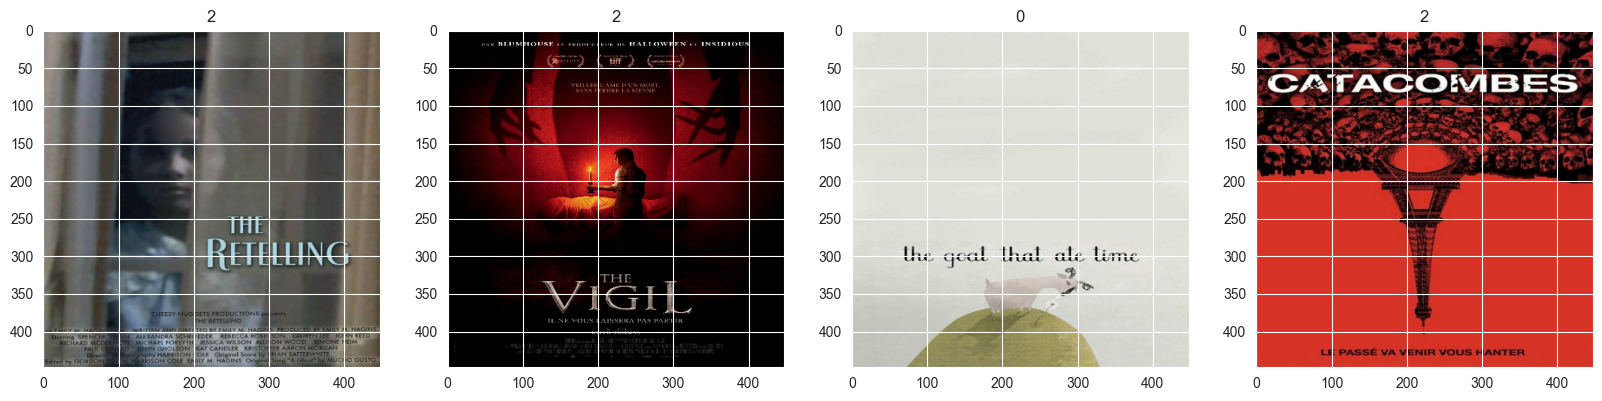

In [17]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [18]:
label_counts = df['genre_of_film'].value_counts().sort_index()
print("Number of images per label:")
print(label_counts)

Number of images per label:
genre_of_film
0     812
1     169
2     791
3     841
4    1160
Name: count, dtype: int64


### 3- Data augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
])

### 4- Create model

In [20]:
# Create model with augmentation
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(448, 448, 3)),
        data_augmentation,
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),  # Reduced from 512
        tf.keras.layers.Dropout(0.3),                   # Reduced from 0.5
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model()

# Compile the model with categorical crossentropy for one-hot labels
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 448, 448, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 448, 448, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   102,760,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,855,237 (392.36 MB)

 Trainable params: 102,855,237 (392.36 MB)

 Non-trainable params: 0 (0.00 B)

#### 5- Split and data

In [21]:
# Calculate exact split sizes
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.2)
test_size = total_samples - train_size - val_size  # Remaining for test

print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

# Convert to number of batches (approximate)
batch_size = 32
train_batches = int(train_size / batch_size)
val_batches = int(val_size / batch_size)
test_batches = int(test_size / batch_size)

# Split the dataset
train = data.take(train_batches)
val = data.skip(train_batches).take(val_batches)
test = data.skip(train_batches + val_batches).take(test_batches)

Train: 2641, Val: 754, Test: 378


In [22]:
# Apply preprocessing
train = train.map(preprocess_data)
val = val.map(preprocess_data)
test = test.map(preprocess_data)

# Add caching and prefetching for performance
train = train.cache().prefetch(tf.data.AUTOTUNE)
val = val.cache().prefetch(tf.data.AUTOTUNE)
test = test.cache().prefetch(tf.data.AUTOTUNE)

### 6- Train and test

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
 2/82 ━━━━━━━━━━━━━━━━━━━━ 8:18 6s/step - accuracy: 0.2578 - loss: 3.4537 

### 7- Performance

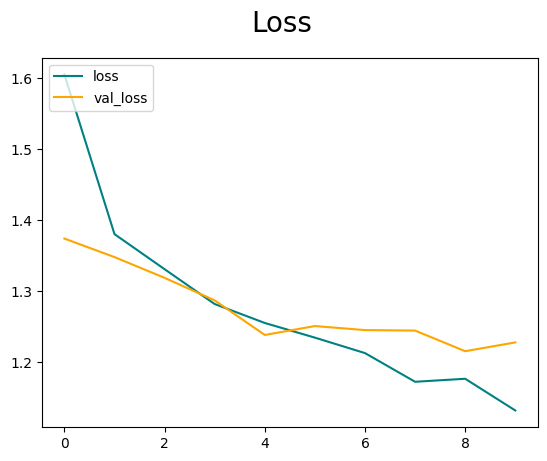

In [136]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

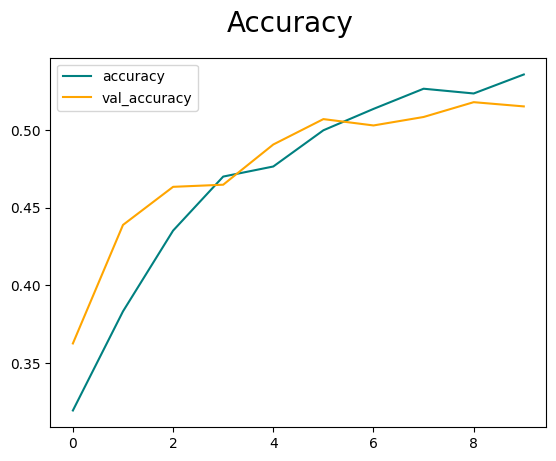

In [137]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluate

In [138]:
test_loss, test_accuracy = model.evaluate(test)
print(f"Test accuracy: {test_accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.5028 - loss: 1.3443
Test accuracy: 0.5028
